In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from itertools import product
import seaborn as sns

from utils.data_acquisition import  fetch_housing_dataset, fetch_wine_dataset
from utils.metrics import mse, accuracy_score, precision_score, recall_score, f1_score
from utils.data_preparation import remove_outliers, min_max_scale, k_fold_split
from models.models import LinearRegression, LogisticRegression
from models.optimizers import GradientDescent, StochasticGradientDescent

## Data Loading


In [2]:
SEED = 42
np.random.seed(SEED)

HOUSING_DF = fetch_housing_dataset()
WINE_DF = fetch_wine_dataset()

# shuffle 
HOUSING_DF = HOUSING_DF.sample(frac=1, random_state=SEED).reset_index(drop=True)
WINE_DF = WINE_DF.sample(frac=1, random_state=SEED).reset_index(drop=True)



# Experiment 1: Basic Performance Comparison

For both datasets, perform an 80/20 train/test split and report the performance metrics on both the training set and test set for each model. Please include metrics such as Mean Squared Error (MSE) for Linear Regression and accuracy, precision, recall, and F1-score for Logistic Regression

### Data Preparation

In [3]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

Analytic Fit:
Train Error:  6.775670736414895
Test Error:  6.1793428679637294
SGD Fit:
Train Error:  17.438201507391877
Test Error:  14.028493332504276


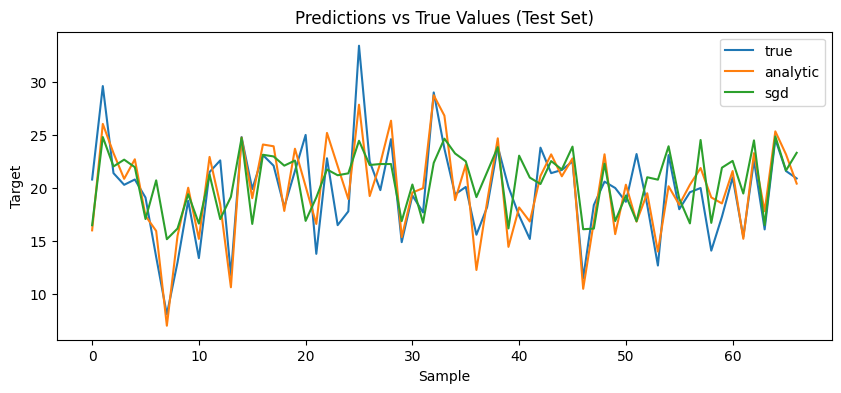

In [4]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}

# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic = lin_reg.predict(X_housing_test)
error_analytic_train =  mse(y_housing_train, lin_reg.predict(X_housing_train))
error_analytic_test = mse(y_housing_test, y_preds_analytic)
w_analytic = np.copy(lin_reg.w)

# mini-batch SGD fit
log_reg = LogisticRegression()
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_sgd= lin_reg.predict(X_housing_test)
error_sgd_train =  mse(y_housing_train, lin_reg.predict(X_housing_train))
error_sgd_test = mse(y_housing_test, y_preds_sgd)


### Results ###
print('Analytic Fit:')
print('Train Error: ', error_analytic_train)
print('Test Error: ', error_analytic_test)
print('SGD Fit:')
print('Train Error: ', error_sgd_train)
print('Test Error: ', error_sgd_test)

plt.figure(figsize=(10,4))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic, label='analytic')
plt.plot(y_preds_sgd, label='sgd')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Target')
plt.legend()
plt.show()

### Logistic Regression

In [5]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False
    }

metrics = ['accuracy', 'precision', 'recall', 'f1']
results = {metric: {'gd_train': 0, 'gd_test': 0, 'sgd_train': 0, 'sgd_test': 0} for metric in metrics}

# GD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
y_wine_train_preds_gd = log_reg.predict(X_wine_train)
y_wine_preds_gd = log_reg.predict(X_wine_test)
w_gd = np.copy(log_reg.w)


# mini-batch SGD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
y_wine_train_preds_sgd = log_reg.predict(X_wine_train)
y_wine_preds_sgd = log_reg.predict(X_wine_test)
w_sgd = np.copy(log_reg.w)

for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
    results[metric]['gd_train'] = metric_func(y_wine_train, y_wine_train_preds_gd)
    results[metric]['gd_test'] = metric_func(y_wine_test, y_wine_preds_gd)
    results[metric]['sgd_train'] = metric_func(y_wine_train, y_wine_train_preds_sgd)
    results[metric]['sgd_test'] = metric_func(y_wine_test, y_wine_preds_sgd)

for metric in metrics:
    print(f'{metric}:\nGD Train: {results[metric]["gd_train"]}\nGD Test: {results[metric]["gd_test"]}\nSGD Train: {results[metric]["sgd_train"]}\nSGD Test: {results[metric]["sgd_test"]}\n')

accuracy:
GD Train: 0.9375
GD Test: 1.0
SGD Train: 0.9140625
SGD Test: 0.9090909090909091

precision:
GD Train: 0.9404787767379679
GD Test: 1.0
SGD Train: 0.9295594262295082
SGD Test: 0.9285714285714286

recall:
GD Train: 0.9375
GD Test: 1.0
SGD Train: 0.9140625
SGD Test: 0.9090909090909091

f1:
GD Train: 0.9367186240731786
GD Test: 1.0
SGD Train: 0.9147736098167133
SGD Test: 0.9105196896501246



### Results

**Linear Regression**
- analytical solution of linear regression performs much better (6 vs 12 MSE)

**Logistic Regression**
- Logistic Regression performs really well on the data
- SGD works better than GD with BS 64
- with BS 8, SGD performs worse than GD

# Experiment 2: Cross-Validation

For both data sets, use a 5-fold cross-validation technique and report the performance metrics on both the training set and test set for each model. Again, include appropriate performance metrics for each model. Check this link for more information.

Note: 5-fold cross-validation is a technique where the dataset is divided into five equal parts (folds), and a model is trained and evaluated five times, each time using a different fold as the validation set and the remain- ing four folds for training.


### Data Preparation

In [6]:
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

X_housing = housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy()
y_housing = housing_df_cleaned.MEDV.to_numpy().reshape(-1,1)

X_wine = wine_df_cleaned.drop(['class'], axis=1).to_numpy()
y_wine = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)

### Linear Regression

In [7]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}

errors_analytic_train = []
errors_analytic_test = []
errors_sgd_train = []
errors_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing, y_housing, n_splits=5):

    # data normalization
    X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

    # analytic fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_fold)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_test_fold)
    errors_analytic_train.append(mse(y_train_fold, y_preds_with_analytic_fit_train))
    errors_analytic_test.append(mse(y_test_fold, y_preds_with_analytic_fit_test))
    w_analytic = np.copy(lin_reg.w)

    # mini-batch SGD fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    y_preds_with_grad_train = lin_reg.predict(X_train_fold)
    y_preds_with_grad_test = lin_reg.predict(X_test_fold)
    errors_sgd_train.append(mse(y_train_fold, y_preds_with_grad_train))
    errors_sgd_test.append(mse(y_test_fold, y_preds_with_grad_test))

print("Analytic Fit Errors:")
print("Train Mean:", np.mean(errors_analytic_train))
print("Train Std:", np.std(errors_analytic_train))
print("Test Mean:", np.mean(errors_analytic_test))
print("Test Std:", np.std(errors_analytic_test))

print("\nMini-Batch SGD Errors:")
print("Train Mean:", np.mean(errors_sgd_train))
print("Train Std:", np.std(errors_sgd_train))
print("Test Mean:", np.mean(errors_sgd_test))
print("Test Std:", np.std(errors_sgd_test))

Analytic Fit Errors:
Train Mean: 6.518268899319205
Train Std: 0.29211560847438856
Test Mean: 7.06242572000018
Test Std: 1.1400669163637573

Mini-Batch SGD Errors:
Train Mean: 16.58830624188537
Train Std: 0.31990749419636666
Test Mean: 16.884959059509438
Test Std: 1.2837189924620558


### Logistic Regression

In [8]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False
    }

# init result lists
metrics = ['accuracy', 'precision', 'recall', 'f1']
results = {metric: {'gd_train': [], 'gd_test': [], 'sgd_train': [], 'sgd_test': []} for metric in metrics}

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine, y_wine):

    # GD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)

    # GD metrics
    y_train_preds_gd = log_reg.predict(X_train_fold)
    y_test_preds_gd = log_reg.predict(X_test_fold)

    for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
        if metric_func.__name__ == 'recall_score':
            results[metric]['gd_train'].append(metric_func(y_train_fold, y_train_preds_gd))
            results[metric]['gd_test'].append(metric_func(y_test_fold, y_test_preds_gd))
        else:
            results[metric]['gd_train'].append(metric_func(y_train_fold, y_train_preds_gd))
            results[metric]['gd_test'].append(metric_func(y_test_fold, y_test_preds_gd))

    # mini-batch SGD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)

    # SGD metrics
    y_train_preds_sgd = log_reg.predict(X_train_fold)
    y_test_preds_sgd = log_reg.predict(X_test_fold)
    for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
        results[metric]['sgd_train'].append(metric_func(y_train_fold, y_train_preds_sgd))
        results[metric]['sgd_test'].append(metric_func(y_test_fold, y_test_preds_sgd))

# compute mean and std for each metric
for metric in metrics:
    print(f"{metric.capitalize()} Results:")
    for key, values in results[metric].items():
        print(f"{key.replace('_', ' ').capitalize()}: Mean {np.mean(values).round(5)}, Std {np.std(values).round(5)}")
    print()  

Accuracy Results:
Gd train: Mean 0.93477, Std 0.01743
Gd test: Mean 0.90076, Std 0.02261
Sgd train: Mean 0.92857, Std 0.03682
Sgd test: Mean 0.91288, Std 0.03671

Precision Results:
Gd train: Mean 0.9404, Std 0.01368
Gd test: Mean 0.91453, Std 0.01436
Sgd train: Mean 0.93294, Std 0.03063
Sgd test: Mean 0.91699, Std 0.03268

Recall Results:
Gd train: Mean 0.93477, Std 0.01743
Gd test: Mean 0.90076, Std 0.02261
Sgd train: Mean 0.92857, Std 0.03682
Sgd test: Mean 0.91288, Std 0.03671

F1 Results:
Gd train: Mean 0.93347, Std 0.01825
Gd test: Mean 0.89895, Std 0.02391
Sgd train: Mean 0.92684, Std 0.03975
Sgd test: Mean 0.91248, Std 0.03716



### Results

**Linear Regression**
- anayltic performs better
- both analytic and SGD have std on test set around 5

**Logistic Regression**
- looks a bit like overfitting
- high standard deviation on test set performance

# Experiment 3: Training Set Sizes
For both datasets, Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test.

### Data Preparation

In [9]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)


### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

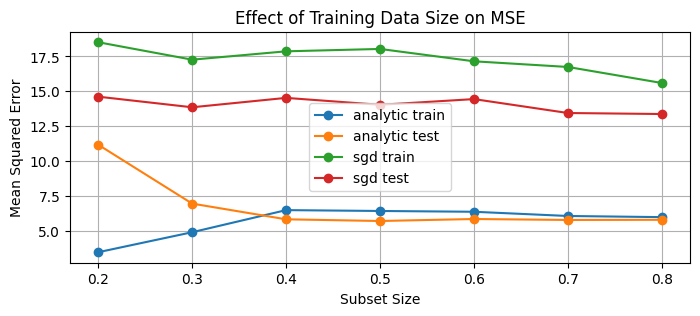

In [10]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

analytic_train_errors = []
analytic_test_errors = []
sgd_train_errors = []
sgd_test_errors = []

for size in sizes:
    # select data subset
    subset_size = int(size * X_housing_train.shape[0])
    X_train_subset = X_housing_train[:subset_size]
    y_train_subset = y_housing_train[:subset_size]

    lin_reg = LinearRegression()

    # analytic fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_subset, y_train_subset, analytic_fit=True, verbose=False)
    y_preds_analytic_train = lin_reg.predict(X_train_subset)
    y_preds_analytic_test = lin_reg.predict(X_housing_test)
    analytic_train_errors.append(mse(y_train_subset, y_preds_analytic_train))
    analytic_test_errors.append(mse(y_housing_test, y_preds_analytic_test))

    # mini-batch SGD fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    y_preds_sgd_train = lin_reg.predict(X_train_subset)
    y_preds_sgd_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_train_subset, y_preds_sgd_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_sgd_test))

plt.figure(figsize=(8,3))
plt.plot(sizes, analytic_train_errors, '-o',label='analytic train')
plt.plot(sizes, analytic_test_errors, '-o',label='analytic test')
plt.plot(sizes, sgd_train_errors, '-o',label='sgd train')
plt.plot(sizes, sgd_test_errors, '-o',label='sgd test')
plt.xlabel('Subset Size')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Training Data Size on MSE')
plt.grid(True)
plt.legend()
plt.show()


### Logistic Regression

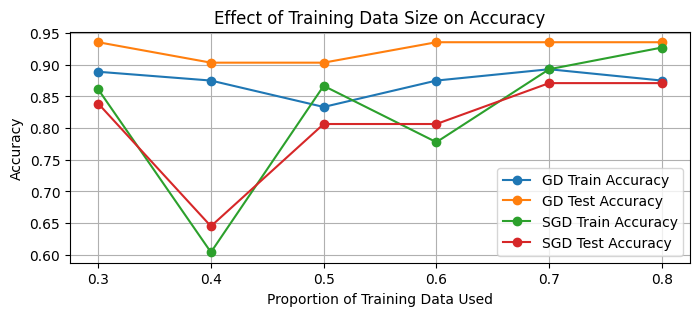

In [11]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False
    }

# sizes to sample
sizes = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

gd_train_accuracies = []
gd_test_accuracies = []
sgd_train_accuracies = []
sgd_test_accuracies = []

for size in sizes:
    # select data subset
    subset_size = int(size * X_wine_train.shape[0])
    X_train_subset = X_wine_train[:subset_size]
    y_train_subset = y_wine_train[:subset_size]
    
    # GD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
    gd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    gd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    
    # mini-batch SGD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
    sgd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))

plt.figure(figsize=(8, 3))
plt.plot(sizes, gd_train_accuracies, '-o', label="GD Train Accuracy")
plt.plot(sizes, gd_test_accuracies, '-o', label="GD Test Accuracy")
plt.plot(sizes, sgd_train_accuracies, '-o', label="SGD Train Accuracy")
plt.plot(sizes, sgd_test_accuracies, '-o', label="SGD Test Accuracy")
plt.xlabel("Proportion of Training Data Used")
plt.ylabel("Accuracy")
plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- generalization performance increases with more data for analytical solution
- for SGD starting with 40%, performance is really stable independent of the amount of data

**Logistic Regression**
- performance peak already with only 40% of the data for training 
- logistic regression performance decreases afterwards
- linear regression stays on some sort of plateau, indicating that not more data is needed
- another time it helps for both

# Experiment 4: Minibatch Sizes
For both datasets, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?
Note: This is for SGD only (Task2, third main task).

### Data Preparation

In [12]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

In [13]:
OPTIMIZER_KWARGS = {
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}

batch_sizes = [1, 4, 8, 16, 32, 64, X_housing_train.shape[0]]

sgd_train_errors = []
sgd_test_errors = []
convergence_speeds = []

for batch_size in batch_sizes:
    lin_reg = LinearRegression()

    start_time = time.time()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_housing_train, y_preds_with_grad_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_with_grad_test))
    convergence_speeds.append(end_time - start_time)

for batch_size, train_error, test_error, speed in zip(batch_sizes, sgd_train_errors, sgd_test_errors, convergence_speeds):
    print(f"Batch Size: {batch_size}, Train Error: {train_error:.5g}, Test Error: {test_error:.5g}, Convergence Speed: {speed:.3g} seconds")

Batch Size: 1, Train Error: 17.494, Test Error: 13.467, Convergence Speed: 0.894 seconds
Batch Size: 4, Train Error: 17.794, Test Error: 13.538, Convergence Speed: 0.879 seconds
Batch Size: 8, Train Error: 17.525, Test Error: 14.056, Convergence Speed: 0.882 seconds
Batch Size: 16, Train Error: 17.562, Test Error: 14.405, Convergence Speed: 0.893 seconds
Batch Size: 32, Train Error: 17.563, Test Error: 13.4, Convergence Speed: 0.912 seconds
Batch Size: 64, Train Error: 17.573, Test Error: 13.468, Convergence Speed: 0.946 seconds
Batch Size: 266, Train Error: 17.411, Test Error: 13.747, Convergence Speed: 1.1 seconds


### Logistic Regression

In [14]:
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False
    }

batch_sizes = [8, 16, 32, 64, X_wine_train.shape[0]]  


sgd_train_accuracies = []
sgd_test_accuracies = []
convergence_speeds = []

for batch_size in batch_sizes:
    log_reg = LogisticRegression()
    
    # mini-batch SGD fit
    start_time = time.time()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    sgd_train_accuracies.append(accuracy_score(y_wine_train, log_reg.predict(X_wine_train)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    convergence_speeds.append(end_time - start_time)

for batch_size, train_acc, test_acc, speed in zip(batch_sizes, sgd_train_accuracies, sgd_test_accuracies, convergence_speeds):
    print(f"Batch size {batch_size}: Train Acc: {train_acc:.5g}, Test Acc: {test_acc:5g}, Convergence Time: {speed:.3g} seconds")

Batch size 8: Train Acc: 0.67969, Test Acc: 0.787879, Convergence Time: 5.43 seconds
Batch size 16: Train Acc: 0.86719, Test Acc: 0.909091, Convergence Time: 5.45 seconds
Batch size 32: Train Acc: 0.94531, Test Acc: 0.878788, Convergence Time: 5.71 seconds
Batch size 64: Train Acc: 0.82812, Test Acc: 0.878788, Convergence Time: 5.99 seconds
Batch size 128: Train Acc: 0.92969, Test Acc: 0.969697, Convergence Time: 6.91 seconds


### Results

**Linear Regression**
- does not really matter

**Logistic Regression**
- best performance with Gradient Descent (whole data set as batch)
- converence fastest with batch size 16, but all very close

# Experiment 5: Different Learning Rates
For both datasets, Present the performance of both linear and logistic regression with at least three different learning rates (your own choice).

### Data Preparation

In [15]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)


### Data Normalization ###
# normalize data after train test split to prevent data leakage
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)

### Linear Regression

Learning Rate: 0.005, Train Error: 20.670, Test Error: 16.819
Learning Rate: 0.01, Train Error: 19.792, Test Error: 16.852
Learning Rate: 0.05, Train Error: 18.234, Test Error: 15.039
Learning Rate: 0.1, Train Error: 17.413, Test Error: 13.837
Learning Rate: 0.2, Train Error: 16.754, Test Error: 12.398
Learning Rate: 0.5, Train Error: 16.013, Test Error: 12.459
Learning Rate: 0.7, Train Error: 15.149, Test Error: 10.298
Learning Rate: 1.0, Train Error: 15.099, Test Error: 11.482


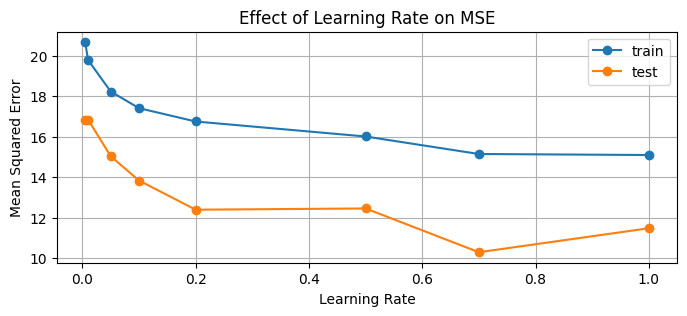

In [16]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'max_iters': 1e4,
    'verbose': False
}
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_errors = []
test_errors = []

for lr in LEARNING_RATES:
    lin_reg = LinearRegression()

    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = lin_reg.predict(X_housing_train)
    y_preds_test = lin_reg.predict(X_housing_test)
    train_errors.append(mse(y_housing_train, y_preds_train))
    test_errors.append(mse(y_housing_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Error: {train_errors[-1]:.3f}, Test Error: {test_errors[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_errors, '-o',label='train')
plt.plot(LEARNING_RATES, test_errors, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Effect of Learning Rate on MSE')
plt.grid(True)
plt.show()


### Logistic Regression

Learning Rate: 0.005, Train Accuracy: 0.891, Test Accuracy: 0.909
Learning Rate: 0.01, Train Accuracy: 0.555, Test Accuracy: 0.697
Learning Rate: 0.05, Train Accuracy: 0.875, Test Accuracy: 0.909
Learning Rate: 0.1, Train Accuracy: 0.930, Test Accuracy: 1.000
Learning Rate: 0.2, Train Accuracy: 0.930, Test Accuracy: 0.970
Learning Rate: 0.5, Train Accuracy: 0.766, Test Accuracy: 0.727
Learning Rate: 0.7, Train Accuracy: 0.781, Test Accuracy: 0.727
Learning Rate: 1.0, Train Accuracy: 0.945, Test Accuracy: 0.939


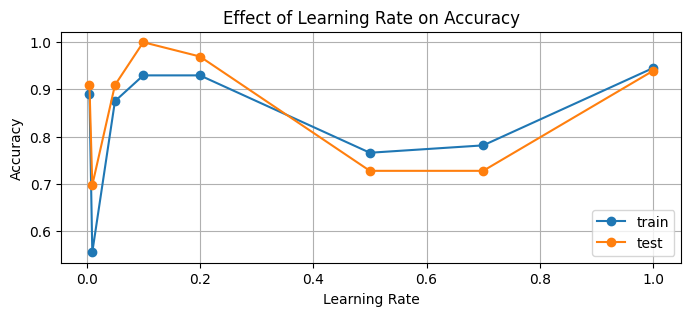

In [17]:
OPTIMIZER_KWARGS = {
    'batch_size': 16,
    'max_iters': 4e4,
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_accuracies = []
test_accuracies = []

for lr in LEARNING_RATES:
    log_reg = LogisticRegression()

    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = log_reg.predict(X_wine_train)
    y_preds_test = log_reg.predict(X_wine_test)
    train_accuracies.append(accuracy_score(y_wine_train, y_preds_train))
    test_accuracies.append(accuracy_score(y_wine_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Accuracy: {train_accuracies[-1]:.3f}, Test Accuracy: {test_accuracies[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_accuracies, '-o',label='train')
plt.plot(LEARNING_RATES, test_accuracies, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- the higher the learning rate, the lower the error
- goes up again a bit after 0.7
- best performance with learning rate 0.7

**Logistic Regression**
- much more unstable, no clear trend
- best performance with learning rate 0.2

# Experiment 6: Different Parameter Configurations
For both datasets, Given a variety of parameter configurations, select a performance metric and present the optimal parameter choice for each dataset. Please provide a rationale for your metric selection, along with an explanation of why you opted for that particular metric

### Linear Regression

In [ ]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 16, 32, 64],
    'LEARNING_RATE': [0.05, 0.1, 0.5, 0.7],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.2

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

housing_df = HOUSING_DF.copy()

count = 1
housing_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    temp_df = housing_df.drop(columns='CHAS')
    temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
    housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

    ### Data Splitting ###
    # split into train and test sets
    X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                        housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                        test_size=TEST_SIZE, random_state=SEED)

    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing_train, y_housing_train, n_splits=3):

        mse_train = []
        mse_val = []

        ### Data Normalization ###
        X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

        lin_reg = LinearRegression()

        start_time = time.time()
        lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = lin_reg.predict(X_train_fold)
        y_preds_sgd_val = lin_reg.predict(X_test_fold)
        mse_train.append(mse(y_train_fold, y_preds_sgd_train))
        mse_val.append(mse(y_test_fold, y_preds_sgd_val))

    # data normalization
    X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

    lin_reg = LinearRegression()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    mse_test = mse(y_housing_test, lin_reg.predict(X_housing_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train MSE': np.mean(mse_train).round(3),
        'Mean Validation MSE': np.mean(mse_val).round(3),
        'Test MSE': mse_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    housing_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val MSE: {np.mean(mse_val).round(3)}, Test MSE: {mse_test.round(3)}, Speed: {np.round((end_time - start_time), 2)}s")
    count += 1

Number of combinations: 360


1: Params: (1.0, 1, 0.05, 10000.0, 0.0), Mean Val MSE: 13.918, Test MSE: 12.451, Speed: 0.79s
2: Params: (1.0, 1, 0.05, 10000.0, 0.5), Mean Val MSE: 13.072, Test MSE: 12.307, Speed: 0.86s


KeyboardInterrupt: 

In [ ]:
# TODO plot results for different parameters
housing_param_search_results_df = pd.DataFrame(housing_param_search_results)

# save results
housing_param_search_results_df.to_csv('results/6/param_search_housing.csv', index=False)

In [ ]:
# load dataframe
housing_param_search_results_df = pd.read_csv('results/6/param_search_housing.csv')

# plot top 10 rows with highest validation mse
housing_param_search_results_df.sort_values(by='Mean Validation MSE', ascending=True).head(20)

,IQR Factor,Batch Size,Learning Rate,Max Iters,Momentum,Mean Train MSE,Mean Validation MSE,Test MSE,Convergence Speed
40,1.0,8,0.5,100000.0,0.5,7.083,6.881,14.288,5.4361
46,1.0,8,0.7,100000.0,0.5,5.975,6.885,14.511,5.7167
119,1.0,64,0.7,100000.0,0.9,6.357,6.935,10.559,6.0090
69,1.0,16,0.7,100000.0,0.0,7.963,7.206,6.413,5.8112
85,1.0,32,0.5,10000.0,0.5,11.497,7.383,14.862,0.5918
94,1.0,32,0.7,100000.0,0.5,7.274,7.641,8.135,5.9135
111,1.0,64,0.5,100000.0,0.0,7.510,7.673,10.322,6.1158
20,1.0,1,0.7,10000.0,0.9,12.207,7.725,53.829,0.6731
65,1.0,16,0.5,100000.0,0.9,7.665,7.758,9.156,5.7991
63,1.0,16,0.5,100000.0,0.0,7.784,8.033,8.252,5.7857


Learning Rate
0.05    9.203
0.10    8.435
0.50    6.474
Name: Mean Validation MSE, dtype: float64


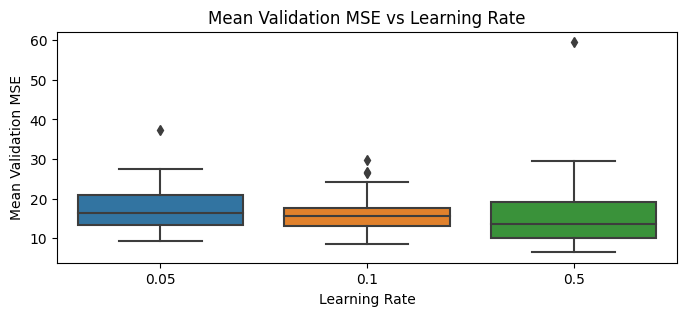

Learning Rate
0.05    7.601
0.10    6.586
0.50    6.408
Name: Test MSE, dtype: float64


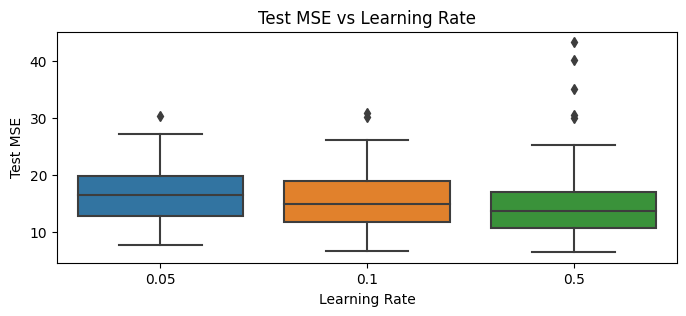

In [ ]:
# validation mse
print(housing_param_search_results_df.groupby('Learning Rate')['Mean Validation MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Mean Validation MSE', data=housing_param_search_results_df)
plt.title('Mean Validation MSE vs Learning Rate')
plt.show()

# test mse
print(housing_param_search_results_df.groupby('Learning Rate')['Test MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Test MSE', data=housing_param_search_results_df)
plt.title('Test MSE vs Learning Rate')
plt.show()

### Logistic Regression

In [ ]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 16, 32],
    'LEARNING_RATE': [0.05, 0.1, 0.5, 0.7],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.20

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

wine_df = WINE_DF.copy()

count = 1
wine_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

    ### Data Splitting ###
    one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
    X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)
    
    acc_train = []
    acc_val = []
    
    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine_train, y_wine_train, n_splits=3):

        log_reg = LogisticRegression()

        start_time = time.time()
        log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = log_reg.predict(X_train_fold)
        y_preds_sgd_val = log_reg.predict(X_test_fold)
        acc_train.append(accuracy_score(y_train_fold, y_preds_sgd_train))
        acc_val.append(accuracy_score(y_test_fold, y_preds_sgd_val))

    log_reg = LogisticRegression()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    acc_test = accuracy_score(y_wine_test, log_reg.predict(X_wine_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train Accuracy': np.mean(acc_train).round(3),
        'Mean Validation Accuracy': np.mean(acc_val).round(3),
        'Test Accuracy': acc_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    wine_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val Acc: {np.mean(acc_val).round(3)}, Test Acc: {acc_test.round(3)}, Speed: {np.round((end_time - start_time), 4)}s")
    count += 1

Number of combinations: 288
1: Params: (1.0, 1, 0.05, 10000.0, 0.0), Mean Val Acc: 0.605, Test Acc: 0.583, Speed: 1.2373s
2: Params: (1.0, 1, 0.05, 10000.0, 0.5), Mean Val Acc: 0.533, Test Acc: 0.667, Speed: 1.2571s
3: Params: (1.0, 1, 0.05, 10000.0, 0.9), Mean Val Acc: 0.541, Test Acc: 0.625, Speed: 1.2608s


KeyboardInterrupt: 

In [8]:
# TODO plot results for different parameters
wine_param_search_results_df = pd.DataFrame(wine_param_search_results)

# save results
wine_param_search_results_df.to_csv('results/6/param_search_wine.csv', index=False)

wine_param_search_results_df.sort_values(by='Mean Validation Accuracy', ascending=False).head(20)

,IQR Factor,Batch Size,Learning Rate,Max Iters,Momentum,Mean Train Accuracy,Mean Validation Accuracy,Test Accuracy,Convergence Speed
51,1.0,16,0.05,100000.0,0.0,0.979,0.947,0.917,8.6666
94,1.0,32,0.70,100000.0,0.5,1.000,0.947,0.917,9.3232
88,1.0,32,0.50,100000.0,0.5,0.957,0.947,0.875,8.9085
47,1.0,8,0.70,100000.0,0.9,0.941,0.946,0.958,8.5213
76,1.0,32,0.05,100000.0,0.5,0.963,0.936,0.958,8.9553
82,1.0,32,0.10,100000.0,0.5,0.958,0.936,0.958,9.0466
59,1.0,16,0.10,100000.0,0.9,0.937,0.926,0.833,9.1458
53,1.0,16,0.05,100000.0,0.9,0.984,0.926,0.917,8.7146
40,1.0,8,0.50,100000.0,0.5,0.957,0.925,0.792,8.2571
75,1.0,32,0.05,100000.0,0.0,0.925,0.925,0.875,8.9454


### Results

**Linear Regression**
- Best Params: 
    - IQR factor: 1.0
    - Batch Size: 32
    - Learning Rate: 0.5
    - Max Epochs: 100000
    - Momentum: 0.5
    - Test MSE: 5.778

**Logistic Regression**
- x

# Experiment 7: Gaussian Basis Functions

Only for dataset1, Gaussian Basis Functions:
- Utilize Gaussian basis functions to enrich the feature set for Dataset 1. • Define each Gaussian basis function as follows:
  
$$\phi_j(x) = exp(-\frac{||x-\mu_j||^2}{2s^2})$$

- Employ a total of 5 Gaussian basis functions.
- Set the spatial scale parameter, s, to a value of 1.
- Select μj values randomly from the training set to determine the centers of these basis functions.
- Use analytical linear regression to predict the target value.
- Compare the target and predicted values obtained with the new dataset with the results obtained with the original feature set, i.e. compare with the results obtained without Gaussian basis functions.

### Data Preparation

In [39]:
IQR_FACTOR = 1.5
TEST_SIZE = 0.2

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

### Data Splitting ###
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)
### Data Normalization ###
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)


In [44]:
num_basis_functions = 5
s = 1.0
feature_index = 0

def calculate_gaussian_basis_functions(x, mu_values, s):
    return [np.exp(-np.linalg.norm(x - mu)**2 / (2 * s**2)) for mu in mu_values]

def compute_basis_features(X, feature_index, mu_values, s):
    num_samples = X.shape[0]
    basis_features = np.empty((num_samples, num_basis_functions))
    for i in range(num_samples):
        basis_features[i, :] = calculate_gaussian_basis_functions(X[i, feature_index], mu_values, s)
    return basis_features

# select random indices to use as mu values
random_indices = np.random.choice(len(X_housing_train), num_basis_functions)
mu_values = X_housing_train[random_indices, feature_index]

# add Gaussian basis functions
basis_functions_train = compute_basis_features(X_housing_train, feature_index, mu_values, s)
X_housing_train_gaussian = np.hstack((X_housing_train, basis_functions_train))
basis_functions_test = compute_basis_features(X_housing_test, feature_index, mu_values, s)
X_housing_test_gaussian = np.hstack((X_housing_test, basis_functions_test))


### Linear Regression

Without Gaussian Basis Functions:
Analytic Fit MSE: 7.576
SGD Fit MSE: 16.449

With Gaussian Basis Functions:
Analytic Fit MSE: 13.049
SGD Fit MSE: 16.442


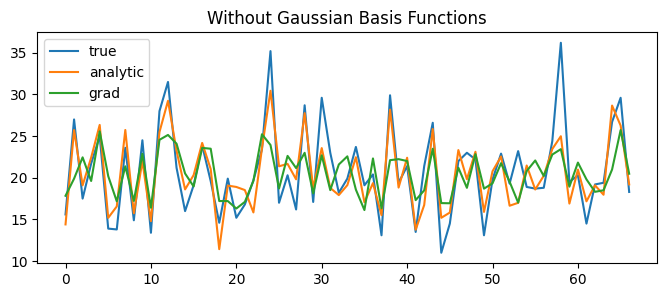

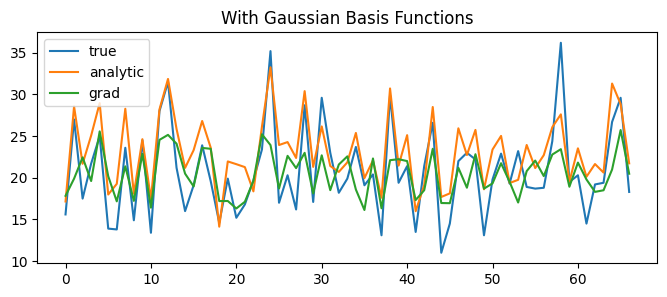

In [43]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e4,
    'verbose': False
}


### Without Gaussian Basis Functions ###
# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic = lin_reg.predict(X_housing_test)
ms_error_analytic = mse(y_housing_test, y_preds_analytic)

# mini-batch SGD fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_sgd = lin_reg.predict(X_housing_test)
ms_error_sgd = mse(y_housing_test, y_preds_sgd)

### With Gaussian Basis Functions ###
# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_gaussian, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic_gaussian = lin_reg.predict(X_housing_test_gaussian)
ms_error_analytic_gaussian = mse(y_housing_test, y_preds_analytic_gaussian)

# mini-batch SGD fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_gaussian, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_sgd_gaussian = lin_reg.predict(X_housing_test_gaussian)
ms_error_sgd_gaussian = mse(y_housing_test, y_preds_sgd_gaussian)

print("Without Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {ms_error_analytic:.3f}")
print(f"SGD Fit MSE: {ms_error_sgd:.3f}")
print("\nWith Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {ms_error_analytic_gaussian:.3f}")
print(f"SGD Fit MSE: {ms_error_sgd_gaussian:.3f}")

plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic, label='analytic')
plt.plot(y_preds_sgd, label='grad')
plt.title('Without Gaussian Basis Functions')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic_gaussian, label='analytic')
plt.plot(y_preds_sgd_gaussian, label='grad')
plt.title('With Gaussian Basis Functions')
plt.legend()
plt.show()

### Results

- adding Gaussian Basis Functions improved the SGD fit very slightly 
- significantly decreased the analytic fit
- in this specific context, may not be helpful when using an analytic method

# Experiment 8: Analytical vs. Mini-Batch Stochastic Gradient Descent
Only for dataset1, Compare analytical linear regression solution with mini-batch stochastic gradient descent- based linear regression solution. What do you find? Why do you think mini-batch stochastic gradient descent is used when an analytical solution is available?

In [ ]:
# TODO: plot mse over timie

### Results

- we can use results from experiments before
- SGD is much faster than analytical solution
- more flexibility in terms of SGD, tuning hyperparameters to the specific problem
- SGD can be used for much larger datasets